# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# # Load Sign Language Dataset from CSV


In [2]:
def load_data():
    train_data = pd.read_csv("C:/Users/abanoup/Downloads/Compressed/Sign Language Dataset/sign_mnist_train/sign_mnist_train.csv") 
    test_data = pd.read_csv("C:/Users/abanoup/Downloads/Compressed/Sign Language Dataset/sign_mnist_test/sign_mnist_test.csv")
    return train_data, test_data

# Preprocess Data


In [3]:
def preprocess_data(data):
    labels = data.iloc[:, 0].values  # Extract labels
    images = data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Normalize and reshape
    images = tf.image.resize(images, (64, 64))  # Resize to (64, 64) for MobileNetV2
    images = tf.image.grayscale_to_rgb(images)  # Convert grayscale (1 channel) to RGB (3 channels)
    return images, labels

# Load and preprocess data

In [4]:
train_data, test_data = load_data()
x_train, y_train = preprocess_data(train_data)
x_test, y_test = preprocess_data(test_data)

# Visualize some training images


In [5]:
def plot_sample_images(images, labels, num_samples=10):
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Define model parameters


In [6]:
input_shape = (64, 64, 3)
num_classes = 26  # Assuming 26 classes for sign language (A-Z)

# Load pre-trained CNN as feature extractor


In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze pretrained layers


C:\Users\abanoup\AppData\Local\Temp\ipykernel_29408\78889021.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


In [8]:
model = Sequential([
    base_model,
    Flatten(),
    Reshape((1, -1)),  # Reshape for LSTM
    Bidirectional(LSTM(256, return_sequences=False)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [9]:
optimizer = Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 5120)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 512)                 │      11,012,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,546,074 (51.67 MB)

 Trainable params: 11,288,090 (43.06 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [12]:
epochs = 5
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), callbacks=[lr_scheduler])


Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 245s 273ms/step - accuracy: 0.2789 - loss: 2.8307 - val_accuracy: 0.6937 - val_loss: 1.5433 - learning_rate: 1.0000e-05
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 251s 293ms/step - accuracy: 0.7710 - loss: 1.1335 - val_accuracy: 0.8101 - val_loss: 0.8869 - learning_rate: 1.0000e-05
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 258s 301ms/step - accuracy: 0.8909 - loss: 0.5609 - val_accuracy: 0.8572 - val_loss: 0.6283 - learning_rate: 1.0000e-05
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 250s 291ms/step - accuracy: 0.9402 - loss: 0.3344 - val_accuracy: 0.8794 - val_loss: 0.4996 - learning_rate: 1.0000e-05
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 245s 285ms/step - accuracy: 0.9682 - loss: 0.2110 - val_accuracy: 0.8954 - val_loss: 0.4237 - learning_rate: 1.0000e-05


🔹 [Training Data Shape]: (27455, 785)
🔹 [Test Data Shape]: (7172, 785)
🔹 [Missing Values]:
 label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


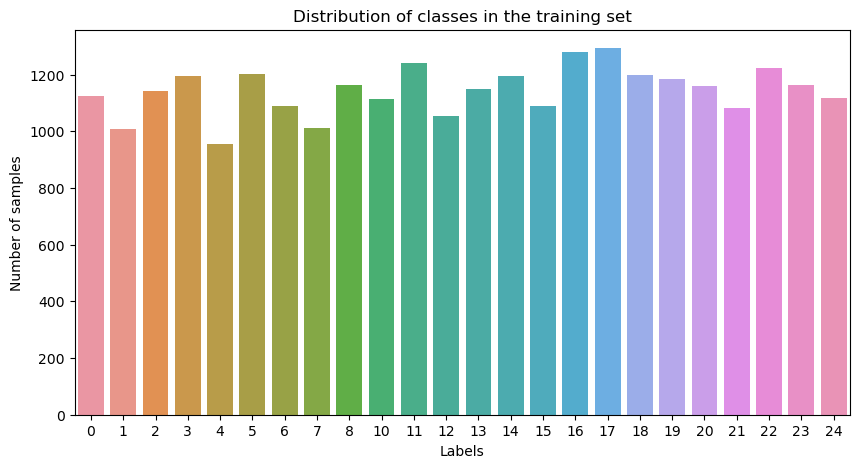

C:\Users\abanoup\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128247 (\N{CAMERA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


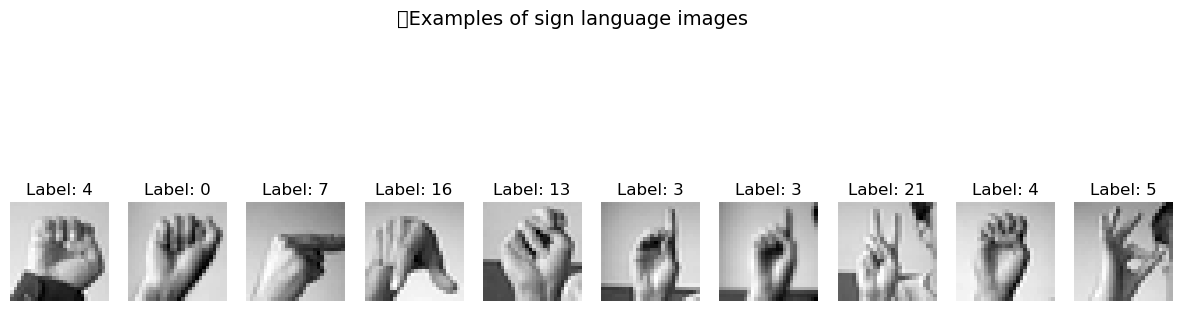

In [16]:
import seaborn as sns
print("🔹 [Training Data Shape]:", train_data.shape)
print("🔹 [Test Data Shape]:", test_data.shape)
print("🔹 [Missing Values]:\n", train_data.isnull().sum())

plt.figure(figsize=(10, 5))
sns.countplot(x=train_data.iloc[:, 0])
plt.title("Distribution of classes in the training set")
plt.xlabel("Labels")
plt.ylabel("Number of samples")
plt.show()

def plot_sample_images(data, num_samples=10):
    images = data.iloc[:, 1:].values.reshape(-1, 28, 28)
    labels = data.iloc[:, 0].values
    indices = np.random.choice(len(data), num_samples, replace=False)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle("📷Examples of sign language images", fontsize=14)
    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].set_title(f"Label: {labels[idx]}")
        axes[i].axis('off')
    plt.show()

plot_sample_images(train_data)

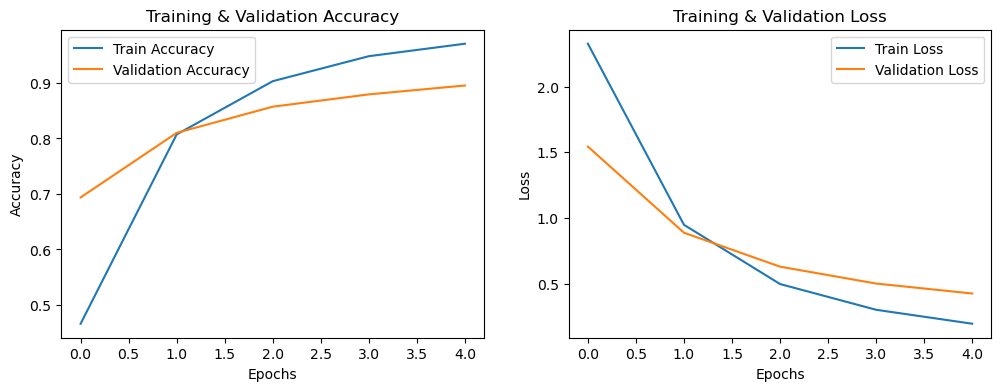

In [17]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    
    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


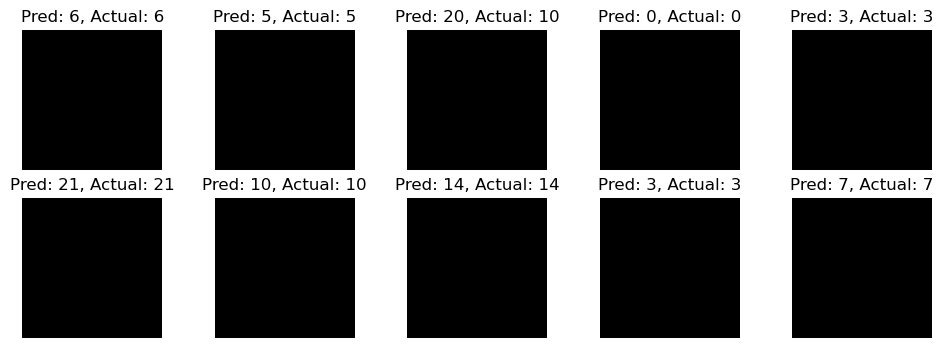

In [18]:

# Visualize predictions
def plot_predictions(model, images, labels, num_samples=10):
    predictions = model.predict(images[:num_samples])
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {predicted_labels[i]}, Actual: {labels[i]}")
        plt.axis("off")
    plt.show()

plot_predictions(model, x_test, y_test)